In [ ]:
# locally
import os
import sys


os.chdir(os.path.dirname(os.getcwd()))

In [6]:
# on Kaggle
import sys
sys.path.append('/kaggle/input/gan-training')

# Пример загрузки обученных моделей

Предварительно желательно отключить логирование в WandB, выставив значение `enable_logging: False` в `logger.yaml`, т.к. в этом ноутбуке оно не понадобится.

Предполагается, что конфигурационные файлы настроены (в частности, указана директория, в которой находится [датасет](https://disk.yandex.ru/d/hcnBVM-FbKdwEQ)).

Хранилище обученных моделей для физических задач находится на Google Диске - [тык](https://drive.google.com/drive/folders/1OiLjp7nSeWke-DHXY5ijvYcmKTRlPkrg?usp=sharing)

Чтобы подключиться к нему через `GDriveStorage`, необходимо авторизоваться в аккаунт, имеющий право на чтение из этой директории. Далее будет рассмотрена авторизация с помощью credentials сервисного аккаунта.

1. Загрузим JSON-файл с credentials по [ссылке](https://drive.google.com/file/d/1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn/view?usp=share_link)

In [7]:
!wget 'https://drive.google.com/u/1/uc?id=1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn&export=download' \
  --output-document 'gdrive_models_storage_key.json'

--2023-05-17 16:36:14--  https://drive.google.com/u/1/uc?id=1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn&export=download
Resolving drive.google.com (drive.google.com)... 108.177.126.102, 108.177.126.139, 108.177.126.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn&export=download [following]
--2023-05-17 16:36:15--  https://drive.google.com/uc?id=1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s2f2oudgf239anj929q66t7thb9fjlfb/1684341375000/04796695416015180161/*/1sIDQJqHJ8RAlS0OZxGCKMTKzDxbPrugn?e=download&uuid=9db747de-5f18-46dd-bc59-abe20994a15e [following]
--2023-05-17 16:36:15--  https://doc-0s-ak-docs.googleuserconten

2. Авторизуемся (потребуется установить библиотеки из `external_storage/requirements.txt`)

In [8]:
from oauth2client.service_account import ServiceAccountCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive


credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "./gdrive_models_storage_key.json",
    scopes = ['https://www.googleapis.com/auth/drive.readonly'],
)
gauth = GoogleAuth()
gauth.credentials = credentials

3. Получим локальное хранилище экспериментов

In [9]:
from pipeline.experiment_setup import experiments_storage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


4. Создадим внешнее храналище

In [10]:
from external_storage.gdrive_storage import GDriveStorage

In [11]:
external_storage = GDriveStorage(experiments_storage,
                                 storage_dir_id='1OiLjp7nSeWke-DHXY5ijvYcmKTRlPkrg',  # ID директории на Google Диске
                                 gauth=gauth)

Проверим, что внешнее хранилище работает, посмотрев список доступных экспериментов:

In [12]:
external_storage.list_available_models()

{'no norm, (1e-03, 1e-05), PRD num_clusters=50': (<ModelParts.CONFIG: 'config'>,
  <ModelParts.TRAINING_CHECKPOINT: 'training_checkpoint'>),
 'test_model': ()}

В возвращаемом этим методом словаре ключе - названия экспериментов, значения - tuple из доступных элементов эксперимента:
- `ModelParts.CONFIG` - файл конфигурации обучения
- `ModelParts.TRAINING_CHECKPOINT` - промежуточное состояние обучения модели (модель, оптимизаторы и т.д.)

---

Теперь можем загружать обученные модели или их конфигурации. Посмотреть конфигурацию обучения для отдельного эксперимента можно через Google Диск, либо загрузив только файл конфигурации обучения в локальное хранилище. Например:

In [13]:
# модель без использования какой-либо нормализации, lr генератора и дискриминатора - 1e-03 и 1e-05 соответственно
experiment_name = 'no norm, (1e-03, 1e-05), PRD num_clusters=50'

In [14]:
from pipeline.storage import ModelParts


external_storage.import_model_part(model_name=experiment_name, part=ModelParts.CONFIG)

Теперь можно удостовериться, что в локальное хранилище экспериментов (директория `./experiments` по умолчанию) был загружен файл конфигурации обучения для данного эксперимента.

Теперь загрузим обученную модель и замерим какую-нибудь метрику.

**Note**: для каждой конфигурации обучения было загружено по одному произвольному результату обучения

In [15]:
# загрузка всей информации об эксперименте (в т.ч. промежуточного состояния обучения и файла конфигурации обучения)
external_storage.import_model(experiment_name)

In [16]:
# сделаем файл конфигурации обучения выбранного эксперимента активным
experiments_storage.load_config(experiment_name)

Config for "no norm, (1e-03, 1e-05), PRD num_clusters=50" was loaded


In [17]:
# получим модель GAN
from config.run_experiment import form_gan_trainer

# указываем число эпох обучения заведомо меньше числа уже пройденных, чтобы обучение не продолжилось
gan_trainer = form_gan_trainer(model_name=experiment_name, n_epochs=-1)
# и делаем шаг процедуры обучения (который не будет успешным, и вернётся загруженный GAN)
try:
    next(gan_trainer)
except StopIteration as err:
    gan = err.value
# в будущем возможно добавление более удобного варианта импорта модели

Checkpoint was loaded. Current epoch: 150


Теперь можем замерить некоторые метрики

In [18]:
# загрузим валидационную выборку
from config.run_experiment import form_dataset


val_dataset = form_dataset(train=False)

In [19]:
# в качестве метрики возьмём усреднённое значение PRD-AUC по бинам по эмбеддингам выходной матрицы
from pipeline.custom_metrics import create_conditional_prd_energy_embed, PhysicsDataStatistics

metric = PhysicsDataStatistics(
    create_conditional_prd_energy_embed(num_clusters=50),
)

In [20]:
# выход метрик не стандартизован, обработку выходов разных метрик можно найти в `pipeline.metrics_logging`
metric_results = metric(gan_model=gan, val_dataset=val_dataset)[0]

100%|██████████| 9/9 [07:07<00:00, 47.55s/it]


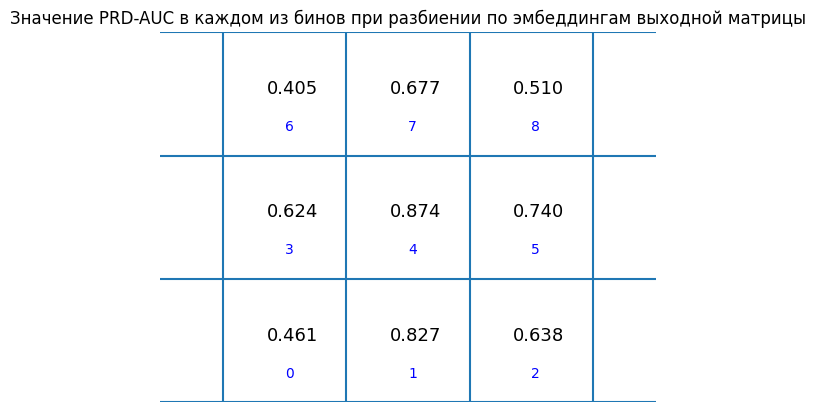

In [21]:
import numpy as np
from matplotlib import pyplot as plt

dims_bins_cnt = [3, 3]
x_lims = [0, 1]
y_lims = [0, 1]
x_bounds = np.linspace(*x_lims, num=dims_bins_cnt[0]+1)
y_bounds = np.linspace(*y_lims, num=dims_bins_cnt[1]+1)

fig, ax = plt.subplots()

ax.axis('equal')
ax.set_xlim(x_bounds[0], x_bounds[-1])
ax.set_ylim(y_bounds[0], y_bounds[-1])
ax.set_xlabel('x')
ax.set_ylabel('y')

for x_bound in x_bounds:
    ax.axvline(x_bound)
for y_bound in y_bounds:
    ax.axhline(y_bound)

for k, val in enumerate(metric_results):
    i = (k % dims_bins_cnt[0])
    j = k // dims_bins_cnt[0]
    x = (x_bounds[i] + x_bounds[i+1]) / 2
    y = (y_bounds[j] + y_bounds[j+1]) / 2
    ax.text(x-0.05, y, f'{val:.3f}', fontsize=13)
    ax.text(x, y-0.1, k, color='blue', fontsize=10)

ax.axis('off')
ax.set_title('Значение PRD-AUC в каждом из бинов при разбиении по эмбеддингам выходной матрицы')
plt.show()

Чёрным в каждом бине указано значение PRD-AUC, синим - индекс бина.

In [22]:
print(f'Среднее значение PRD-AUC по эмбеддингам выходной матрицы: {np.mean(metric_results):.3f}')

Среднее значение PRD-AUC по эмбеддингам выходной матрицы: 0.640
